In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import seaborn as sns
from pathlib import Path

In [76]:
path = Path().cwd()
dataPath = path / "data" / "HR_data.csv" #path.parent

data = pd.read_csv(dataPath)
set(data.dtypes)

data.sort_values(['Cohort', 'Round', 'Phase'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [101]:
# Import Data
Data_results = copy.copy(data.iloc[:,1:52])
types = ['Round','Phase','Cohort','Individual','Puzzler']
Data_type = copy.copy(data[types])
Data_answers = copy.copy(data.iloc[:,54:].drop(columns=types[2:]))

# Convert to int
for t in types[:3]:
    # print(set(Data_type[t]))
    Data_type[t] = Data_type[t].str[-1].astype(int)
Data_type

# Fill NaNs
Data_results = Data_results.fillna(Data_results.mean())
Data_answers = Data_answers.fillna(Data_answers.median())


# for d in [Data_results,Data_type,Data_answers]:
#     print(np.sum(d.isnull().any(axis=0)))

# ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired','nervous', 'attentive', 'afraid', 'active', 'determined']

pos_list = ['inspired','attentive','active','determined']
ten_list = ['Frustrated']

new_columns = {}
for col in Data_answers:
    if col in ten_list:
        Data_answers[col] = Data_answers[col].values/2
    if col not in pos_list:
        print(f'{col} is flipped')
        new_columns[col] = col + '_flip'
        Data_answers[col] = 5-Data_answers[col]

Data_answers.rename(columns=new_columns, inplace=True)

real_cols = Data_answers.columns
Data_answers['mean'] = Data_answers[real_cols].mean(axis=1)
Data_answers['min'] = Data_answers[real_cols].min(axis=1)
Data_answers['max'] = Data_answers[real_cols].max(axis=1)

Data_answers


Frustrated is flipped
upset is flipped
hostile is flipped
alert is flipped
ashamed is flipped
nervous is flipped
afraid is flipped


,Frustrated_flip,upset_flip,hostile_flip,alert_flip,ashamed_flip,inspired,nervous_flip,attentive,afraid_flip,active,determined,mean,min,max
0,5.0,4.0,4.0,4.0,4.0,1.0,3.0,2.0,4.0,1.0,2.0,3.090909,1.0,5.0
1,4.5,4.0,4.0,2.0,4.0,3.0,3.0,3.0,4.0,2.0,2.0,3.227273,2.0,4.5
2,4.5,4.0,4.0,3.0,4.0,2.0,3.0,3.0,4.0,2.0,3.0,3.318182,2.0,4.5
3,4.0,4.0,4.0,1.0,4.0,3.0,2.0,3.0,4.0,2.0,3.0,3.090909,1.0,4.0
4,2.5,4.0,4.0,4.0,4.0,3.0,2.0,1.0,4.0,1.0,3.0,2.954545,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,5.0,4.0,4.0,3.0,4.0,2.0,4.0,2.0,4.0,2.0,2.0,3.272727,2.0,5.0
308,3.0,3.0,2.0,1.0,4.0,2.0,3.0,4.0,4.0,4.0,4.0,3.090909,1.0,4.0
309,4.5,4.0,4.0,3.0,4.0,2.0,3.0,2.0,4.0,2.0,2.0,3.136364,2.0,4.5
310,5.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,4.0,2.0,3.0,3.454545,2.0,5.0


In [33]:
# fig, ax = plt.subplots(1, 1, figsize=(24,20))
# sns.heatmap(Data_results.corr(), ax=ax, cmap="gist_rainbow");

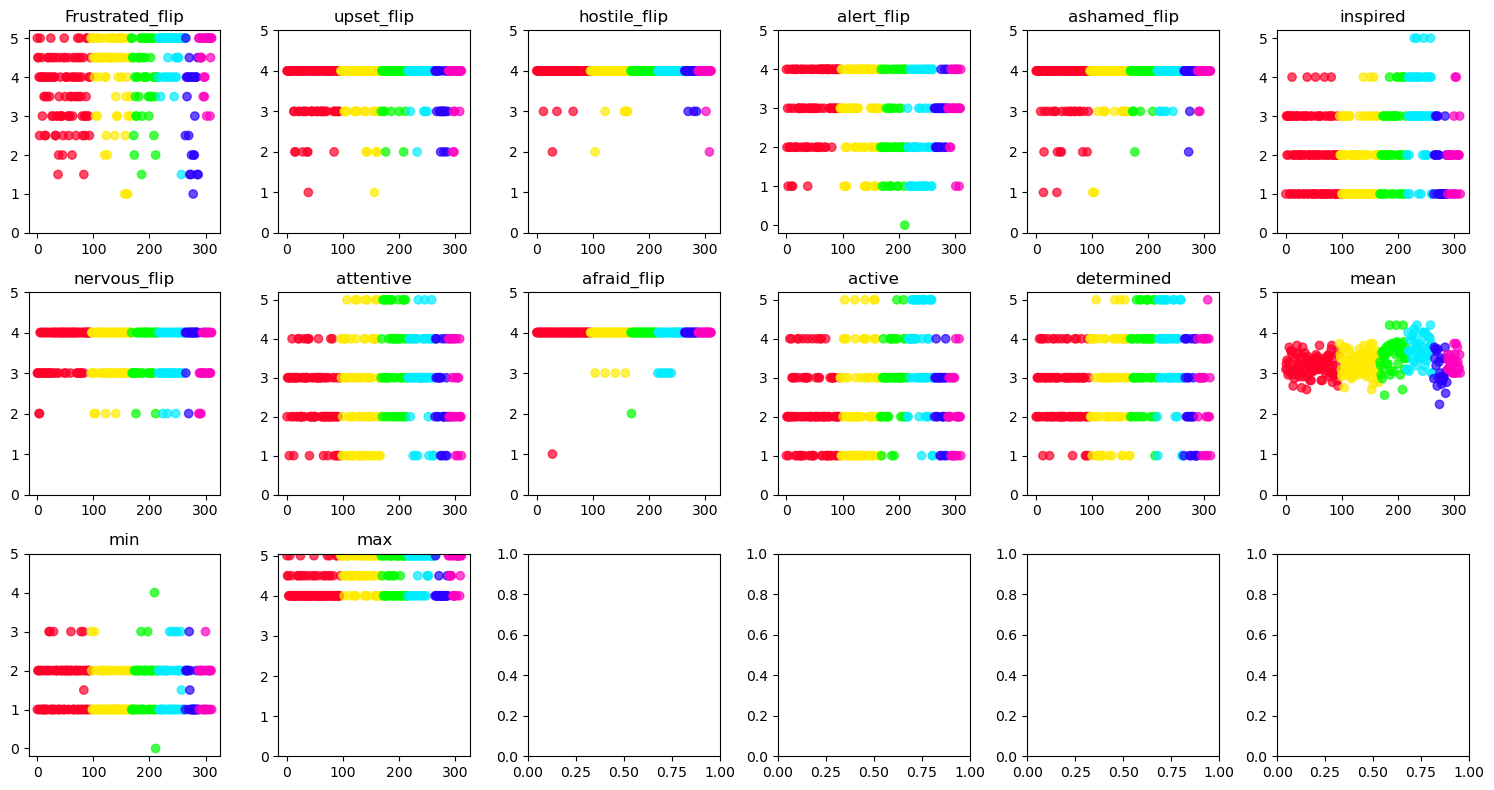

In [103]:
import math
def plotstuff(data,c=Data_type['Cohort'].values,fix=False):
    num_cols = 6
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns) / num_cols), ncols=num_cols, figsize=(15, 8)) 
    axes = axes.flatten()

    for i, col in enumerate(data.columns):
        ax = axes[i]
        
        scatter = ax.scatter(
            data.index, 
            data[col], 
            c = c,
            cmap='gist_rainbow',
            alpha=0.7
        )
        
        ax.set_title(col)
        if fix:
            ax.set_yticks(range(0, 6))

    plt.tight_layout()
    plt.show()

# plotstuff(Data_results.iloc[:,:12])
# plotstuff(Data_results.iloc[:,12:24])
# plotstuff(Data_results.iloc[:,24:36])
# plotstuff(Data_results.iloc[:,36:48])
# plotstuff(Data_results.iloc[:,48:])

plotstuff(Data_answers,fix=True)


In [54]:
from collections import Counter

Counter(Data_answers['Individual']);

In [ ]:
import plotly.express as px
import pandas as pd

In [95]:
Data_answers.iloc[:2]

,Individual,Puzzler,Frustrated,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined
0,1,1,2.0,1.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,2.0
1,1,1,3.0,2.0,1.0,3.0,2.0,2.0,2.0,3.0,1.0,3.0,3.0


In [103]:
df = Data_answers.iloc[:]

df = df[df['Puzzler'] == 0]
df = df.iloc[:,2:]

# Build list of dimensions manually with forced ranges
dimensions = []
for col in df.columns:
    max_val = df[col].max()
    if max_val <= 5:  
        if col in ['inspired','attentive','active','determined']: 
            dimensions.append({'range': [5, 0],'label': col,'values': df[col]})
        else:
            dimensions.append({'range': [0, 5],'label': col,'values': df[col]})
    elif max_val <=10:
        dimensions.append({'range': [0, 10],'label': col,'values': df[col]})


# Create parallel coordinates plot
fig = px.parallel_coordinates(
    df,
    color="Frustrated",
    color_continuous_scale=px.colors.diverging.Tealrose
)

# Override the default dimensions with our forced ranges
fig.update_traces(dimensions=dimensions)
fig.show()
